## Import Dependancies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))

In [14]:
from src.model_eval import evaluate_model, get_column_importances, roc_plot_threshold
from src.model_pipeline import get_train_test_data, preprocess_features, train_model
from src.plots import barchart_1x2, boxplot_1x2, corr_heatmap

In [15]:
data_df = pd.read_csv("../data/input/flight_test.csv")
history_df = pd.read_csv("../data/input/flight_history.csv")

## Reusable functions
- `get_hour(time)`
- `barchart_1x2(df, y_column, x_columns_list, order_bars=False)`
- `corr_heatmap(df, target_column=None, font_size=12)`
- `get_train_test_data(data_df, target_column, test_size=0.25, random_state=42)`
- `preprocess_features(categorical_features, numeric_features=None)`
- `train_model(X_train, y_train, preprocessor, classifier)`
- `evaluate_model(model, X_test, y_test)`
- `get_column_importances(model, preprocessor, numeric_features, categorical_features)`

In [ ]:
def get_hour(time_hhmm):
    time_hhmm = str(time_hhmm).zfill(4)
    return int(time_hhmm[:2])


def export_predictions_with_flags(y_test_pred: pd.Series, y_train_pred: pd.Series, filepath: str):
    """Concat prediction with actuals and its features into single dataframe."""
    # TODO: Refactor this function to use the new data pipeline
    # Original Data Non-feature Columns
    df_inferance = data_2_df[list(data_2_df.columns.difference(categorical_features + numeric_features + [target_column]))]

    # Training data for help investigate misclassifications
    y_test_df = pd.DataFrame(y_test, columns=["lateflight"]).reset_index(drop=True)
    y_test_pred_df = pd.DataFrame(y_test_pred, columns=["predicted"])
    test_df = pd.concat([X_test.reset_index(drop=True), y_test_df, y_test_pred_df], axis=1)
    test_2_df = test_df.merge(df_inferance, on=["uniqueid"], how="left")
    test_2_df["split"] = "test"

    # Training data for help investigate misclassifications
    y_train_df = pd.DataFrame(y_train, columns=["lateflight"]).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred, columns=["predicted"])
    train_df = pd.concat([X_train.reset_index(drop=True), y_train_df, y_train_pred_df], axis=1)
    train_2_df = train_df.merge(df_inferance, on=["uniqueid"], how="left")
    train_2_df["split"] = "train"

    flight_test_pred_df = pd.concat([train_2_df, test_2_df], axis=0)

    flight_test_pred_df.to_csv(filepath, index=False)

## flight_test
- Based on the number of unique values and possible relationship with target variable, some of the columns can be ignored/dropped.
- Feature columns: day, carrier, origin, dest, hour, sched_dep_time, sched_arr_time, time_hour
    - day_of_week can be derived using `time_hour` that may help prediction as weekends could be more busy that results in delays
    - arrival hour of the day can be derived as some hours are more busy than others
        - `sched_arr_time` needed to adjust the format to HHMM, so hour can be extracted
    - departure hour of the day is available as `hour`
- `Dest` column has too many values and some of the columns has very few occurences in dataset, this feature can be excluded from the model 
- Target column: lateflight
    - 47% of flights are late and there are some rows with missing values
- Other columns may not be useful for modeling : uniqueid, year, month, flight, tailnum, minute
    - year and month is same for all rows
    - flight number is not unique overall, same flight number can be used for different airlines
    - tailnum is registration number, it is specific to actual flight

In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uniqueid        6000 non-null   int64  
 1   year            6000 non-null   int64  
 2   month           6000 non-null   int64  
 3   day             6000 non-null   int64  
 4   sched_dep_time  6000 non-null   int64  
 5   sched_arr_time  6000 non-null   int64  
 6   carrier         6000 non-null   object 
 7   flight          6000 non-null   int64  
 8   tailnum         5948 non-null   object 
 9   origin          6000 non-null   object 
 10  dest            6000 non-null   object 
 11  hour            6000 non-null   int64  
 12  minute          6000 non-null   int64  
 13  time_hour       6000 non-null   object 
 14  lateflight      5786 non-null   float64
dtypes: float64(1), int64(9), object(5)
memory usage: 703.3+ KB


In [18]:
data_df.head()

,uniqueid,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,tailnum,origin,dest,hour,minute,time_hour,lateflight
0,1,2013,7,14,1440,1749,DL,1902,N965DL,LGA,PBI,14,40,2013-07-14 14:00:00,0.0
1,2,2013,7,7,945,1305,AA,1871,N3AJAA,LGA,MIA,9,45,2013-07-07 09:00:00,0.0
2,3,2013,7,5,1200,1435,DL,1947,N608DA,LGA,ATL,12,0,2013-07-05 12:00:00,0.0
3,4,2013,7,22,650,808,EV,5811,N16919,EWR,BUF,6,50,2013-07-22 06:00:00,1.0
4,5,2013,7,2,1630,1930,AA,881,N3FCAA,JFK,DFW,16,30,2013-07-02 16:00:00,1.0


In [19]:
data_df.describe(include="all")

,uniqueid,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,tailnum,origin,dest,hour,minute,time_hour,lateflight
count,6000.000000,6000.0,6000.0,6000.000000,6000.000000,6000.000000,6000,6000.000000,5948,6000,6000,6000.000000,6000.000000,6000,5786.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,2231,3,92,NaN,NaN,558,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,UA,NaN,N735MQ,EWR,ORD,NaN,NaN,2013-07-01 06:00:00,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1045,NaN,17,2071,319,NaN,NaN,27,NaN
mean,3000.500000,2013.0,7.0,16.178167,1337.640833,1507.523667,NaN,1955.623333,NaN,NaN,NaN,13.106333,27.007500,NaN,0.466298
std,1732.195139,0.0,0.0,8.931445,475.595256,516.961621,NaN,1612.297057,NaN,NaN,NaN,4.738928,19.425224,NaN,0.498906
min,1.000000,2013.0,7.0,1.000000,500.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,5.000000,0.000000,NaN,0.000000
25%,1500.750000,2013.0,7.0,9.000000,900.000000,1102.750000,NaN,580.000000,NaN,NaN,NaN,9.000000,9.000000,NaN,0.000000
50%,3000.500000,2013.0,7.0,16.000000,1354.000000,1539.000000,NaN,1497.000000,NaN,NaN,NaN,13.000000,29.000000,NaN,0.000000
75%,4500.250000,2013.0,7.0,24.000000,1726.000000,1932.000000,NaN,3384.000000,NaN,NaN,NaN,17.000000,45.000000,NaN,1.000000


In [20]:
data_df["arr_hour"] = data_df["sched_arr_time"].apply(get_hour)
data_df["dep_dayofweek"] = pd.to_datetime(data_df["time_hour"]).dt.dayofweek

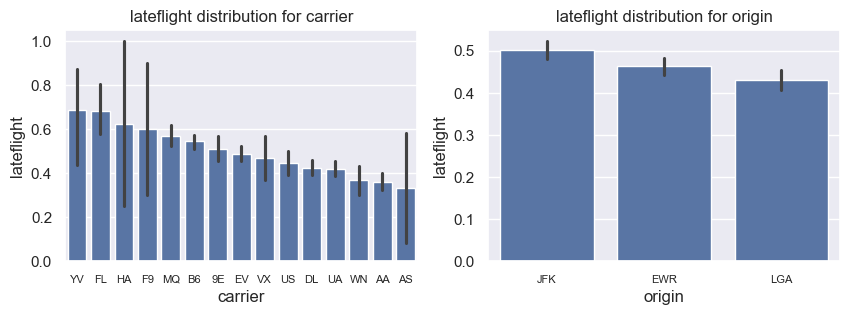

In [21]:
barchart_1x2(data_df, "lateflight", ["carrier", "origin"], order_bars=True)

In [22]:
(
    data_df.groupby("dest")["lateflight"].agg(count="count", mean="mean").sort_values(by="count", ascending=False).head(10),
    data_df.groupby("dest")["lateflight"].agg(count="count", mean="mean").sort_values(by="count", ascending=True).head(10),
)

(      count      mean
 dest                 
 LAX     308  0.396104
 ORD     305  0.432787
 ATL     289  0.584775
 BOS     254  0.433071
 SFO     251  0.525896
 MCO     246  0.439024
 CLT     233  0.527897
 MIA     212  0.372642
 FLL     203  0.517241
 DTW     161  0.378882,
       count      mean
 dest                 
 BZN       1  0.000000
 MYR       1  1.000000
 PVD       1  0.000000
 BUR       2  0.000000
 ALB       2  0.000000
 ANC       2  0.500000
 CAE       3  1.000000
 TUL       3  1.000000
 AVL       3  0.666667
 BHM       4  0.500000)

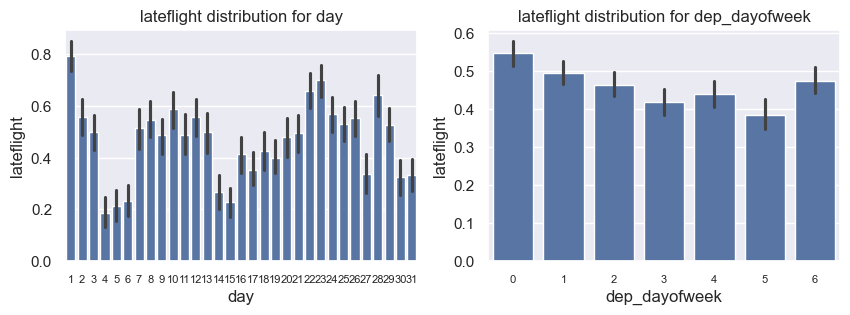

In [23]:
barchart_1x2(data_df, "lateflight", ["day", "dep_dayofweek"])

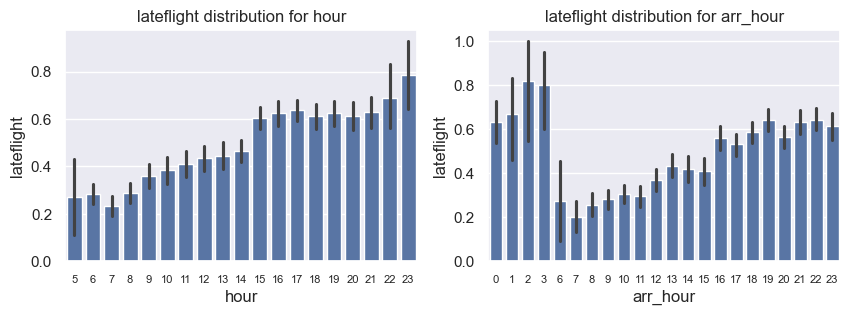

In [24]:
barchart_1x2(data_df, "lateflight", ["hour", "arr_hour"])

In [25]:
data_df.head()

,uniqueid,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,tailnum,origin,dest,hour,minute,time_hour,lateflight,arr_hour,dep_dayofweek
0,1,2013,7,14,1440,1749,DL,1902,N965DL,LGA,PBI,14,40,2013-07-14 14:00:00,0.0,17,6
1,2,2013,7,7,945,1305,AA,1871,N3AJAA,LGA,MIA,9,45,2013-07-07 09:00:00,0.0,13,6
2,3,2013,7,5,1200,1435,DL,1947,N608DA,LGA,ATL,12,0,2013-07-05 12:00:00,0.0,14,4
3,4,2013,7,22,650,808,EV,5811,N16919,EWR,BUF,6,50,2013-07-22 06:00:00,1.0,8,0
4,5,2013,7,2,1630,1930,AA,881,N3FCAA,JFK,DFW,16,30,2013-07-02 16:00:00,1.0,19,1


                lateflight
sched_dep_time    0.281795
hour              0.281565
sched_arr_time    0.212313
arr_hour          0.211992
flight            0.030392
minute            0.029948
day               0.007739
dep_dayofweek    -0.069954


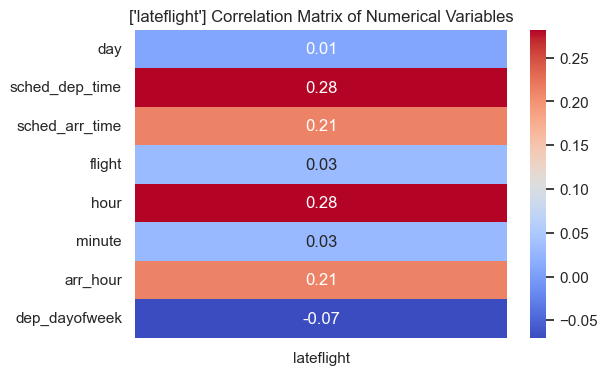

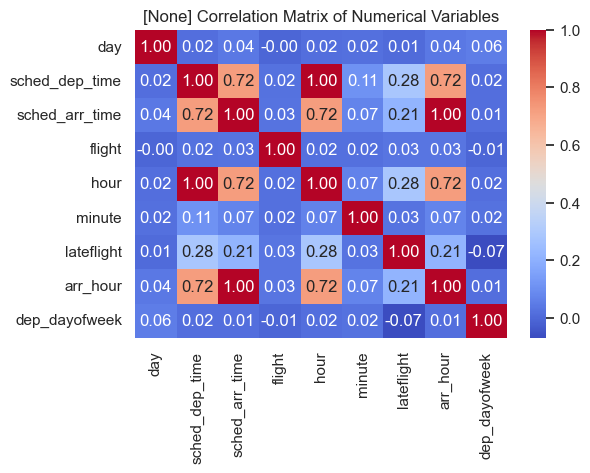

In [26]:
corr_heatmap(data_df.drop(columns=["uniqueid", "year", "month"]), "lateflight")
corr_heatmap(data_df.drop(columns=["uniqueid", "year", "month"]))

### flight_history
- Additional features available in this dataset are: `distance`, `air_time`, `dep_delay`, `arr_delay`, however `lateflight` target column is not available
- There is 6 months of data same year as flight_test
- time columns need format clean up to extract arrival hour of the day if needed
- distance can be appended from this dataset to main dataset
- % of delayed flights for each carrier can be calculated and appended to main dataset

In [27]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166158 entries, 0 to 166157
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            166158 non-null  int64  
 1   month           166158 non-null  int64  
 2   day             166158 non-null  int64  
 3   dep_time        161275 non-null  float64
 4   sched_dep_time  166158 non-null  int64  
 5   dep_delay       161275 non-null  float64
 6   arr_time        161057 non-null  float64
 7   sched_arr_time  166158 non-null  int64  
 8   arr_delay       160678 non-null  float64
 9   carrier         166158 non-null  object 
 10  flight          166158 non-null  int64  
 11  tailnum         164637 non-null  object 
 12  origin          166158 non-null  object 
 13  dest            166158 non-null  object 
 14  air_time        160678 non-null  float64
 15  distance        166158 non-null  int64  
 16  hour            166158 non-null  int64  
 17  minute    

In [28]:
history_df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00


In [29]:
history_df.describe(include="all")

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
count,166158.0,166158.000000,166158.000000,161275.000000,166158.000000,161275.000000,161057.000000,166158.000000,160678.00000,166158,166158.000000,164637,166158,166158,160678.000000,166158.000000,166158.000000,166158.000000,166158
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,3825,3,100,NaN,NaN,NaN,NaN,3439
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UA,NaN,N725MQ,EWR,ATL,NaN,NaN,NaN,NaN,2013-06-10 06:00:00
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28936,NaN,393,60718,8538,NaN,NaN,NaN,NaN,87
mean,2013.0,3.551836,15.642515,1351.740567,1346.872128,13.715666,1503.949024,1539.488595,8.15129,NaN,1970.258651,NaN,NaN,NaN,150.564377,1026.744183,13.208964,25.975752,NaN
std,0.0,1.699779,8.724071,490.410054,468.257735,41.677452,536.363552,498.562131,46.00005,NaN,1655.041538,NaN,NaN,NaN,93.399122,726.054153,4.669139,19.279158,NaN
min,2013.0,1.000000,1.000000,1.000000,500.000000,-33.000000,1.000000,1.000000,-86.00000,NaN,1.000000,NaN,NaN,NaN,20.000000,80.000000,5.000000,0.000000,NaN
25%,2013.0,2.000000,8.000000,909.000000,909.000000,-5.000000,1106.000000,1125.000000,-16.00000,NaN,553.000000,NaN,NaN,NaN,82.000000,502.000000,9.000000,7.000000,NaN
50%,2013.0,4.000000,16.000000,1407.000000,1400.000000,-1.000000,1538.000000,1600.000000,-4.00000,NaN,1464.000000,NaN,NaN,NaN,131.000000,872.000000,14.000000,29.000000,NaN
75%,2013.0,5.000000,23.000000,1748.000000,1730.000000,12.000000,1945.000000,1950.000000,15.00000,NaN,3697.000000,NaN,NaN,NaN,191.000000,1389.000000,17.000000,44.000000,NaN


In [30]:
history_df["lateflight"] = history_df["arr_delay"].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else None))
history_df["arr_hour"] = history_df["sched_arr_time"].apply(get_hour)
history_df["dep_dayofweek"] = pd.to_datetime(history_df["time_hour"]).dt.dayofweek

In [31]:
history_df.describe(include="all")

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,lateflight,arr_hour,dep_dayofweek
count,166158.0,166158.000000,166158.000000,161275.000000,166158.000000,161275.000000,161057.000000,166158.000000,160678.00000,166158,166158.000000,164637,166158,166158,160678.000000,166158.000000,166158.000000,166158.000000,166158,160678.000000,166158.000000,166158.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,3825,3,100,NaN,NaN,NaN,NaN,3439,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UA,NaN,N725MQ,EWR,ATL,NaN,NaN,NaN,NaN,2013-06-10 06:00:00,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28936,NaN,393,60718,8538,NaN,NaN,NaN,NaN,87,NaN,NaN,NaN
mean,2013.0,3.551836,15.642515,1351.740567,1346.872128,13.715666,1503.949024,1539.488595,8.15129,NaN,1970.258651,NaN,NaN,NaN,150.564377,1026.744183,13.208964,25.975752,NaN,0.419286,15.108078,2.916616
std,0.0,1.699779,8.724071,490.410054,468.257735,41.677452,536.363552,498.562131,46.00005,NaN,1655.041538,NaN,NaN,NaN,93.399122,726.054153,4.669139,19.279158,NaN,0.493444,4.977234,1.974256
min,2013.0,1.000000,1.000000,1.000000,500.000000,-33.000000,1.000000,1.000000,-86.00000,NaN,1.000000,NaN,NaN,NaN,20.000000,80.000000,5.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,2013.0,2.000000,8.000000,909.000000,909.000000,-5.000000,1106.000000,1125.000000,-16.00000,NaN,553.000000,NaN,NaN,NaN,82.000000,502.000000,9.000000,7.000000,NaN,0.000000,11.000000,1.000000
50%,2013.0,4.000000,16.000000,1407.000000,1400.000000,-1.000000,1538.000000,1600.000000,-4.00000,NaN,1464.000000,NaN,NaN,NaN,131.000000,872.000000,14.000000,29.000000,NaN,0.000000,16.000000,3.000000
75%,2013.0,5.000000,23.000000,1748.000000,1730.000000,12.000000,1945.000000,1950.000000,15.00000,NaN,3697.000000,NaN,NaN,NaN,191.000000,1389.000000,17.000000,44.000000,NaN,1.000000,19.000000,5.000000


In [32]:
(
    history_df.groupby("dest")["lateflight"].agg(count="count", mean="mean").sort_values(by="count", ascending=False).head(10),
    history_df.groupby("dest")["lateflight"].agg(count="count", mean="mean").sort_values(by="count", ascending=True).head(10),
)

(      count      mean
 dest                 
 ATL    8300  0.463855
 ORD    7923  0.380285
 LAX    7549  0.350642
 BOS    7428  0.323775
 MCO    6991  0.422829
 CLT    6461  0.458753
 FLL    6306  0.458135
 SFO    6007  0.354753
 MIA    5722  0.369102
 DCA    4754  0.453934,
       count      mean
 dest                 
 EYW       7  0.428571
 JAC       8  0.625000
 HDN      12  0.500000
 MTJ      12  0.333333
 TVC      15  0.333333
 BZN      15  0.533333
 PSP      16  0.312500
 CHO      27  0.333333
 CAE      48  0.833333
 MVY      52  0.346154)

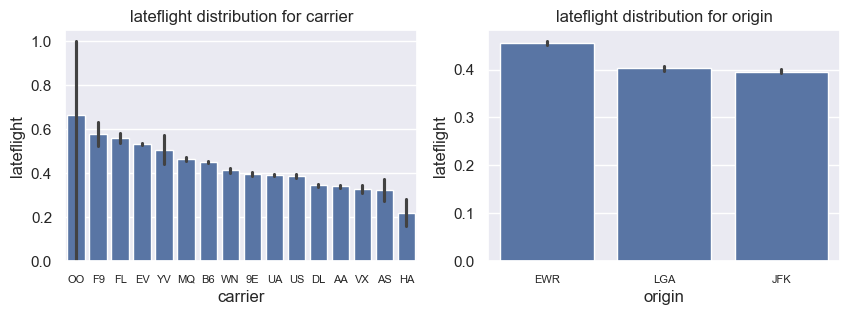

In [33]:
barchart_1x2(history_df, "lateflight", ["carrier", "origin"], order_bars=True)

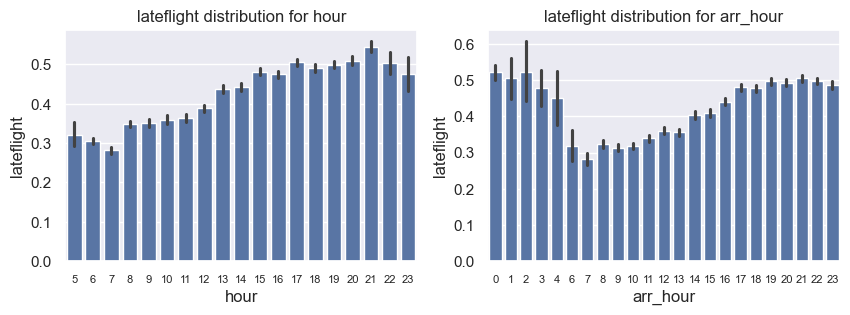

In [34]:
barchart_1x2(history_df, "lateflight", ["hour", "arr_hour"])

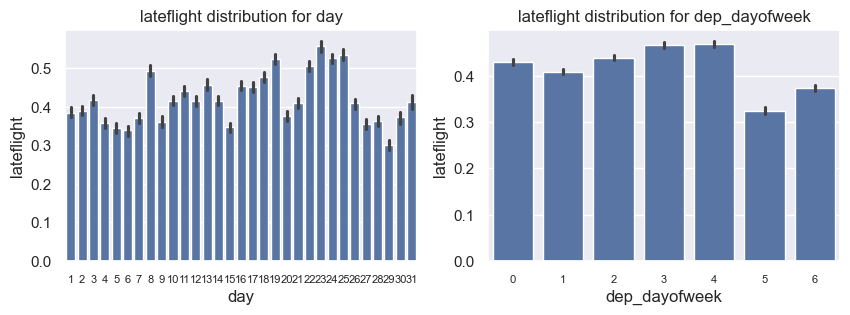

In [35]:
barchart_1x2(history_df, "lateflight", ["day", "dep_dayofweek"])

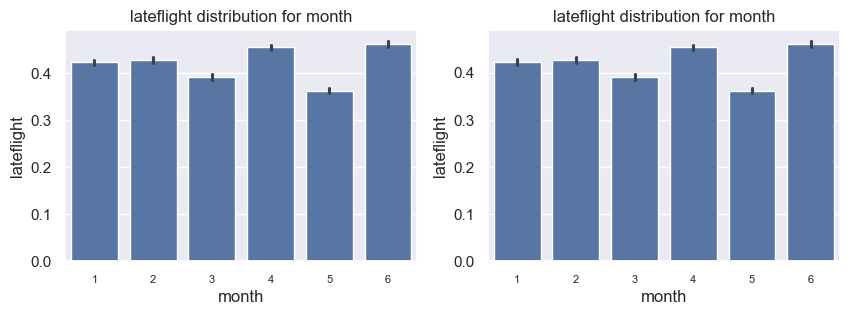

In [36]:
barchart_1x2(history_df, "lateflight", ["month", "month"])

                lateflight
arr_delay         0.617388
dep_delay         0.455667
dep_time          0.194225
sched_dep_time    0.155705
hour              0.154959
sched_arr_time    0.121592
arr_hour          0.121162
arr_time          0.083267
flight            0.074622
minute            0.028996
day               0.028108
month             0.005977
air_time         -0.017506
dep_dayofweek    -0.038505
distance         -0.053410


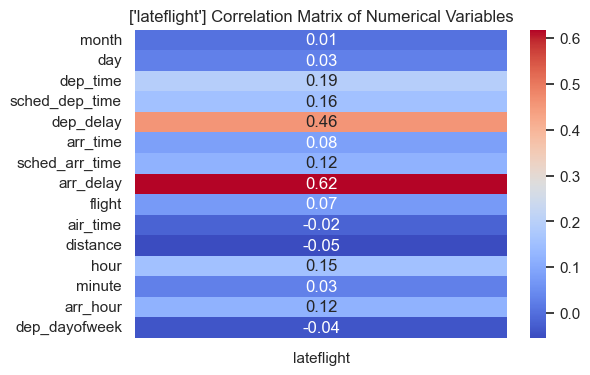

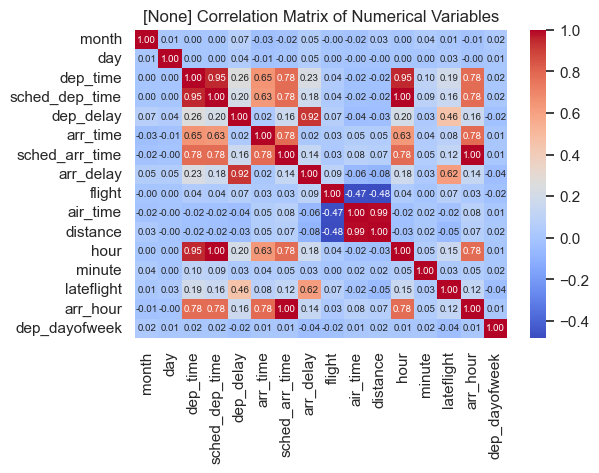

In [37]:
corr_heatmap(history_df.drop(columns=["year"]), "lateflight")
corr_heatmap(history_df.drop(columns=["year"]), font_size=7)

### Compare flight_test and flight_history for consitency in patterns

In [38]:
history_df.groupby("month")["lateflight"].mean()

month
1    0.422380
2    0.427767
3    0.391334
4    0.454288
5    0.362237
6    0.461311
Name: lateflight, dtype: float64

In [39]:
print(
    data_df[["carrier", "flight"]].drop_duplicates().shape,
    history_df[["carrier", "flight"]].drop_duplicates().shape,
    history_df[~history_df["carrier"].isin(data_df["carrier"].unique())][["carrier", "flight"]].drop_duplicates().shape,
    history_df["carrier"].nunique(),
    data_df["carrier"].nunique(),
)

print(data_df.groupby(["carrier", "flight"]).size().sort_values(ascending=True).head(10))

filter_df = data_df[["carrier", "flight"]].drop_duplicates()
filtered_history_df = history_df.merge(filter_df, on=["carrier", "flight"], how="inner")

print(data_df[["carrier", "flight"]].drop_duplicates().shape, filtered_history_df[["carrier", "flight"]].drop_duplicates().shape)

(1310, 2) (4060, 2) (2, 2) 16 15
carrier  flight
UA       421       1
         775       1
         774       1
         770       1
         769       1
         759       1
EV       5395      1
UA       743       1
EV       5483      1
         5559      1
dtype: int64
(1310, 2) (1224, 2)


flight_test


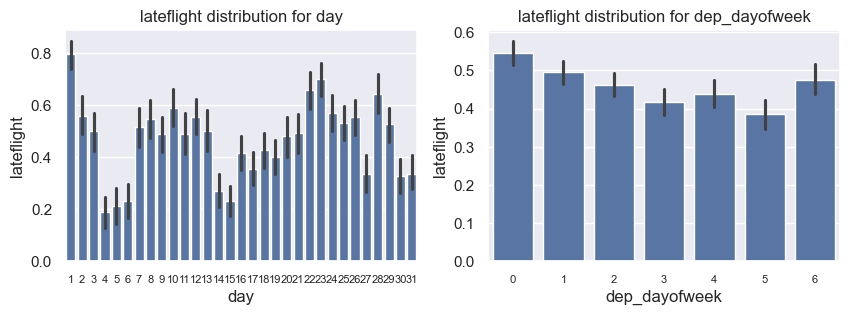

filtered flight_history


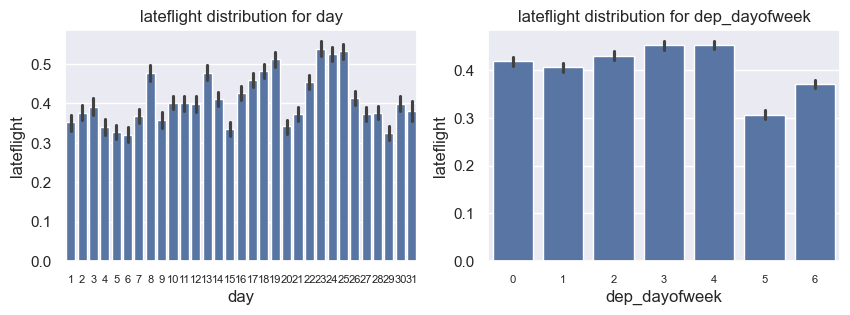

flight_history


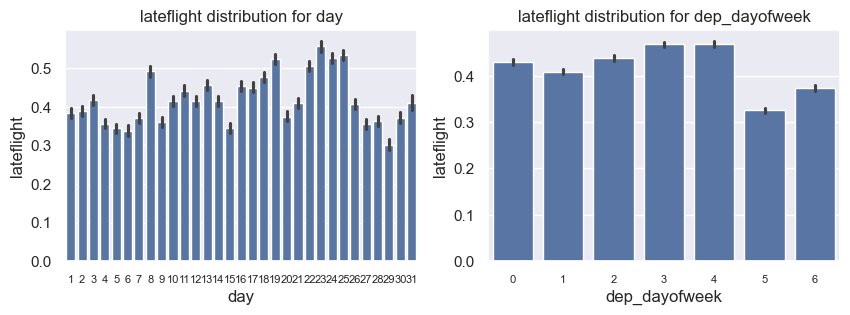

In [40]:
# "day", "dep_dayofweek"
print("flight_test")
barchart_1x2(data_df, "lateflight", ["day", "dep_dayofweek"])
# print("June flight_history")
# barchart_1x2(history_df[history_df["month"] == 6], "lateflight", ["day", "dep_dayofweek"])
print("filtered flight_history")
barchart_1x2(filtered_history_df, "lateflight", ["day", "dep_dayofweek"])
print("flight_history")
barchart_1x2(history_df, "lateflight", ["day", "dep_dayofweek"])

flight_test


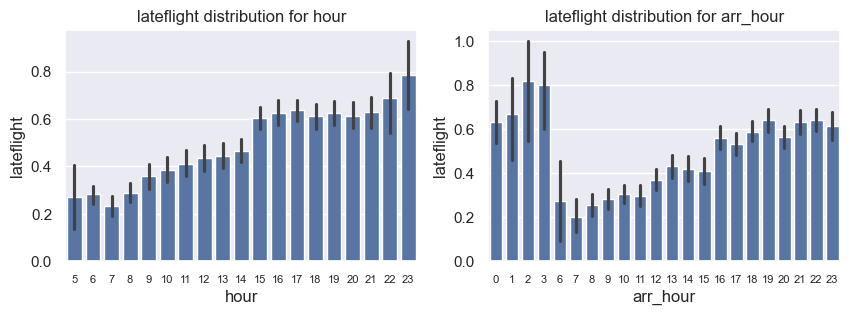

filtered flight_history


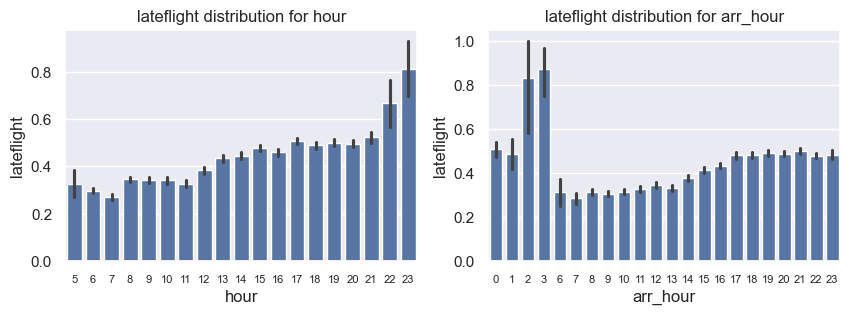

flight_history


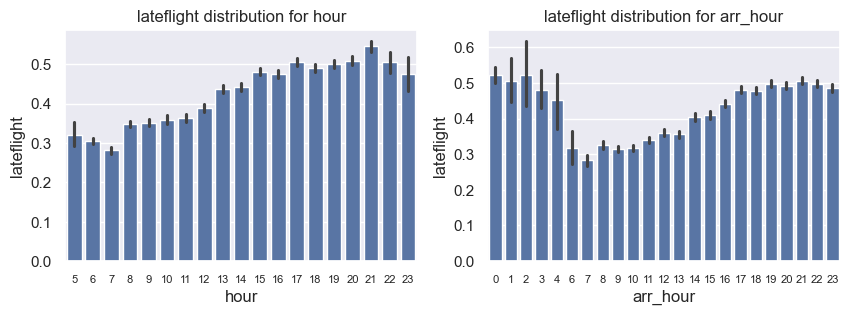

In [41]:
# "hour", "arr_hour"
print("flight_test")
barchart_1x2(data_df, "lateflight", ["hour", "arr_hour"])
print("filtered flight_history")
barchart_1x2(filtered_history_df, "lateflight", ["hour", "arr_hour"])
print("flight_history")
barchart_1x2(history_df, "lateflight", ["hour", "arr_hour"])

flight_test


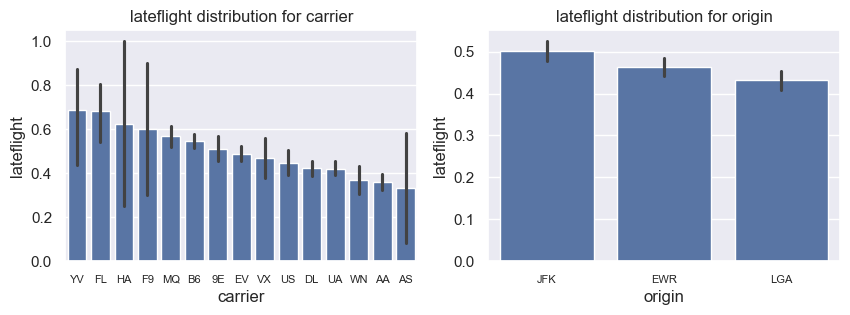

filtered flight_history


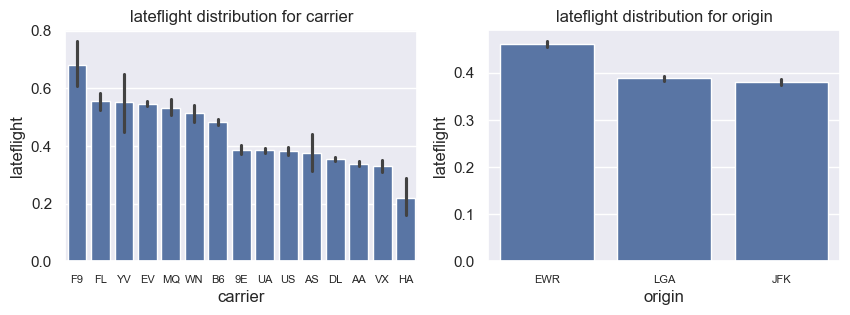

flight_history


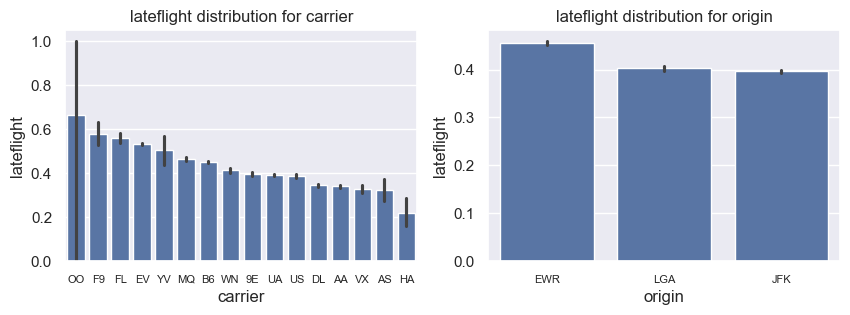

In [42]:
# "carrier", "origin"
print("flight_test")
barchart_1x2(data_df, "lateflight", ["carrier", "origin"], order_bars=True)
print("filtered flight_history")
barchart_1x2(filtered_history_df, "lateflight", ["carrier", "origin"], order_bars=True)
print("flight_history")
barchart_1x2(history_df, "lateflight", ["carrier", "origin"], order_bars=True)

filtered_history_df


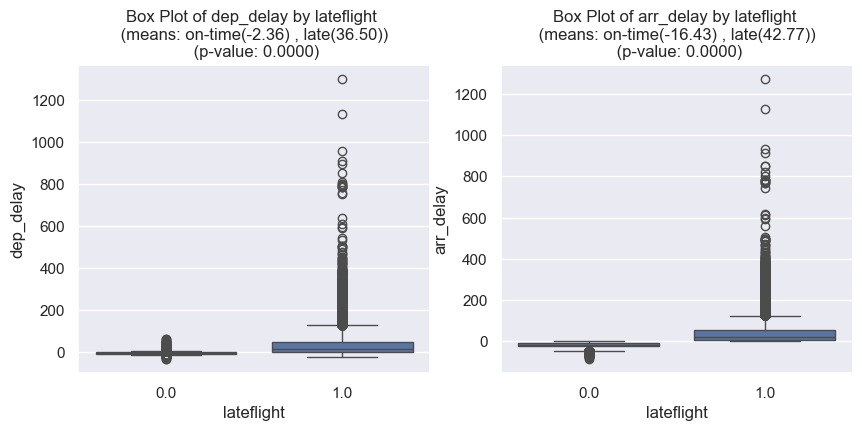

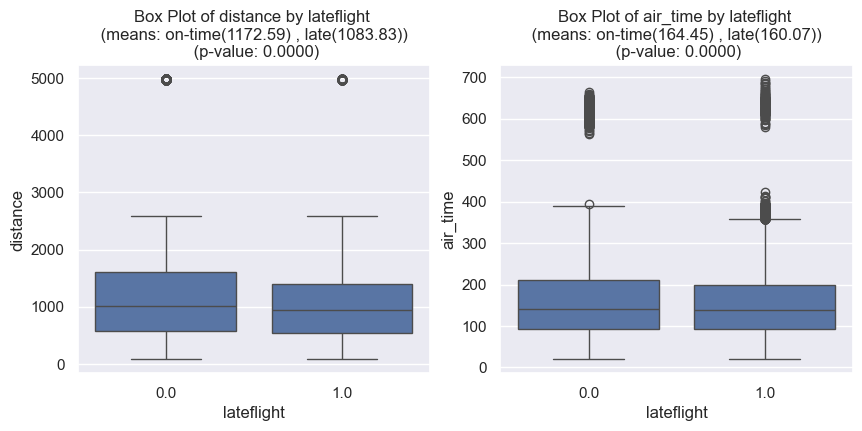

In [43]:
print("filtered_history_df")
boxplot_1x2(filtered_history_df, "lateflight", ["dep_delay", "arr_delay"])
boxplot_1x2(filtered_history_df, "lateflight", ["distance", "air_time"])

In [44]:
dest_test = data_df.groupby("dest")["lateflight"].agg(count_test="count", mean_test="mean")
dest_history = filtered_history_df.groupby("dest")["lateflight"].agg(count_history="count", mean_history="mean")
dest_df = dest_test.merge(dest_history, on=["dest"], how="left")
dest_df.sort_values(by="count_test", ascending=False).head(10)

,count_test,mean_test,count_history,mean_history
dest,,,,
LAX,308,0.396104,5817.0,0.346055
ORD,305,0.432787,4427.0,0.365259
ATL,289,0.584775,5473.0,0.428102
BOS,254,0.433071,3628.0,0.296307
SFO,251,0.525896,4109.0,0.358481
MCO,246,0.439024,4245.0,0.409187
CLT,233,0.527897,2644.0,0.473903
MIA,212,0.372642,3832.0,0.362996
FLL,203,0.517241,2931.0,0.456841


### Extract Features from flight_history dataset

In [45]:
distances_df = filtered_history_df[["origin", "dest", "distance"]].drop_duplicates()

dep_delay_df = filtered_history_df.groupby(["carrier", "flight"])["dep_delay"].agg(dep_delay="median").reset_index()
arr_delay_df = filtered_history_df.groupby(["carrier", "flight"])["arr_delay"].agg(arr_delay="median").reset_index()

air_time_df = filtered_history_df.groupby(["carrier", "flight", "origin", "dest"])["air_time"].agg(air_time="median").reset_index()

filtered_history_df["speed"] = (filtered_history_df["distance"] / filtered_history_df["air_time"]) * 60
carrier_speed_df = filtered_history_df.groupby(["carrier", "flight"])["speed"].agg(speed="median").reset_index()

In [46]:
carrier_delay_df = filtered_history_df.groupby(["carrier"])["lateflight"].agg(carrier_delay="mean").reset_index()
origin_delay_df = filtered_history_df.groupby(["origin"])["lateflight"].agg(origin_delay="mean").reset_index()
dest_delay_df = filtered_history_df.groupby(["dest"])["lateflight"].agg(dest_delay="mean").reset_index()
origin_dest_delay_df = filtered_history_df.groupby(["origin", "dest"])["lateflight"].agg(origin_dest_delay="mean").reset_index()
day_delay_df = filtered_history_df.groupby(["day"])["lateflight"].agg(day_delay="mean").reset_index()
dayofweek_delay_df = filtered_history_df.groupby(["dep_dayofweek"])["lateflight"].agg(dayofweek_delay="mean").reset_index()
carrier_flight_delay_df = filtered_history_df.groupby(["carrier", "flight"])["lateflight"].agg(carrier_flight_delay="mean").reset_index()
tailnum_delay_df = filtered_history_df.groupby(["tailnum"])["lateflight"].agg(tailnum_delay="mean").reset_index()

### Append Features from flight_history to flight_test

In [47]:
print(data_df.shape)
data_2_df = (
    data_df.merge(distances_df, on=["origin", "dest"], how="left")
    .merge(dep_delay_df, on=["carrier", "flight"], how="left")
    .merge(arr_delay_df, on=["carrier", "flight"], how="left")
    .merge(air_time_df, on=["carrier", "flight", "origin", "dest"], how="left")
    .merge(carrier_speed_df, on=["carrier", "flight"], how="left")
    .merge(carrier_delay_df, on=["carrier"], how="left")
    .merge(origin_delay_df, on=["origin"], how="left")
    .merge(dest_delay_df, on=["dest"], how="left")
    .merge(origin_dest_delay_df, on=["origin", "dest"], how="left")
    .merge(day_delay_df, on=["day"], how="left")
    .merge(dayofweek_delay_df, on=["dep_dayofweek"], how="left")
    .merge(carrier_flight_delay_df, on=["carrier", "flight"], how="left")
    .merge(tailnum_delay_df, on=["tailnum"], how="left")
)
print(data_2_df.shape)

(6000, 17)
(6000, 30)


In [48]:
data_2_df.describe(include="all")

,uniqueid,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,tailnum,origin,dest,hour,minute,time_hour,lateflight,arr_hour,dep_dayofweek,distance,dep_delay,arr_delay,air_time,speed,carrier_delay,origin_delay,dest_delay,origin_dest_delay,day_delay,dayofweek_delay,carrier_flight_delay,tailnum_delay
count,6000.000000,6000.0,6000.0,6000.000000,6000.000000,6000.000000,6000,6000.000000,5948,6000,6000,6000.000000,6000.000000,6000,5786.000000,6000.000000,6000.000000,5974.000000,5714.000000,5713.000000,5228.000000,5713.000000,6000.000000,6000.000000,5998.000000,5974.000000,6000.000000,6000.000000,5713.000000,5836.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,2231,3,92,NaN,NaN,558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,UA,NaN,N735MQ,EWR,ORD,NaN,NaN,2013-07-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1045,NaN,17,2071,319,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3000.500000,2013.0,7.0,16.178167,1337.640833,1507.523667,NaN,1955.623333,NaN,NaN,NaN,13.106333,27.007500,NaN,0.466298,14.784000,2.671500,1065.593237,4.243175,1.454052,151.853003,398.921265,0.435052,0.410967,0.422936,0.428359,0.410307,0.408738,0.450066,0.432343
std,1732.195139,0.0,0.0,8.931445,475.595256,516.961621,NaN,1612.297057,NaN,NaN,NaN,4.738928,19.425224,NaN,0.498906,5.154005,1.988277,746.439291,14.880446,18.981416,93.145763,52.298929,0.080243,0.036947,0.081551,0.100797,0.064443,0.043754,0.189432,0.162373
min,1.000000,2013.0,7.0,1.000000,500.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,5.000000,0.000000,NaN,0.000000,0.000000,0.000000,94.000000,-8.000000,-47.000000,30.500000,151.578947,0.220994,0.380494,0.000000,0.000000,0.319744,0.306507,0.000000,0.000000
25%,1500.750000,2013.0,7.0,9.000000,900.000000,1102.750000,NaN,580.000000,NaN,NaN,NaN,9.000000,9.000000,NaN,0.000000,11.000000,1.000000,529.000000,-3.000000,-9.000000,84.000000,375.172414,0.354194,0.380494,0.360539,0.354227,0.357576,0.405538,0.303571,0.333333
50%,3000.500000,2013.0,7.0,16.000000,1354.000000,1539.000000,NaN,1497.000000,NaN,NaN,NaN,13.000000,29.000000,NaN,0.000000,15.000000,2.000000,912.500000,-0.500000,-3.000000,133.000000,410.588235,0.386203,0.388297,0.428102,0.415406,0.398812,0.418541,0.439024,0.428571
75%,4500.250000,2013.0,7.0,24.000000,1726.000000,1932.000000,NaN,3384.000000,NaN,NaN,NaN,17.000000,45.000000,NaN,1.000000,19.000000,4.000000,1411.000000,4.500000,5.000000,195.000000,435.746606,0.512915,0.461667,0.471831,0.474347,0.459893,0.451524,0.570000,0.520833


                      lateflight
sched_dep_time          0.281795
hour                    0.281565
carrier_flight_delay    0.237981
sched_arr_time          0.212313
arr_hour                0.211992
arr_delay               0.199381
dep_delay               0.161268
carrier_delay           0.093367
day_delay               0.093282
origin_dest_delay       0.087317
tailnum_delay           0.067643
dest_delay              0.055881
flight                  0.030392
minute                  0.029948
dayofweek_delay         0.026542
day                     0.007739
speed                   0.000833
air_time               -0.009870
origin_delay           -0.009924
distance               -0.012837
dep_dayofweek          -0.069954


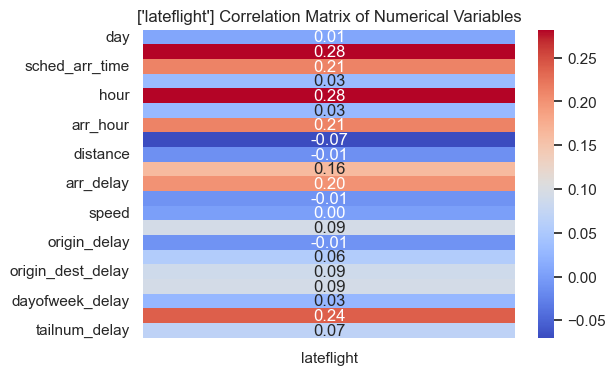

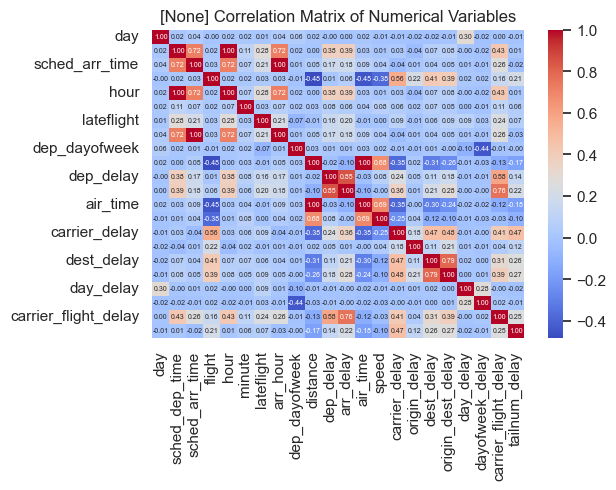

In [49]:
corr_heatmap(data_2_df.drop(columns=["uniqueid", "year", "month"]), "lateflight")
corr_heatmap(data_2_df.drop(columns=["uniqueid", "year", "month"]), font_size=5)

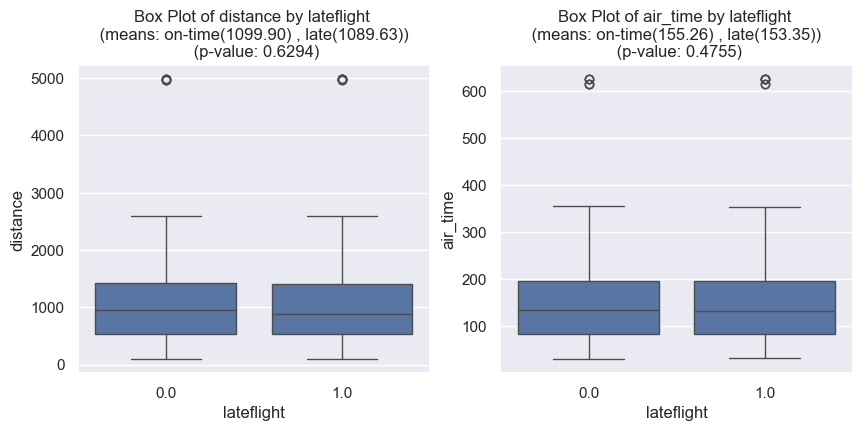

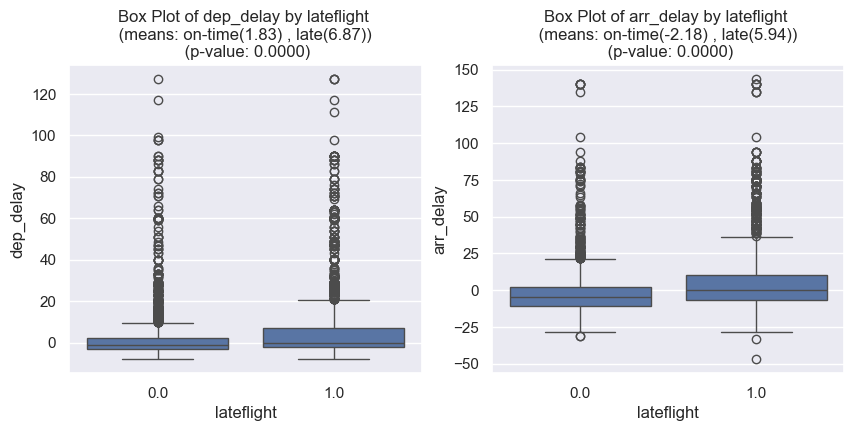

In [50]:
boxplot_1x2(data_2_df, "lateflight", ["distance", "air_time"])
boxplot_1x2(data_2_df, "lateflight", ["dep_delay", "arr_delay"])

## Modeling
- Type of Prediction: the objective is to predict the target variable `lateflight` which is binary of `{1:"Late", 0:"Ontime"}`, this is binary classification prediction, the models selected later in this notebook is to achieve that outcome with general high accuracy.
- Feature Selection
    - categorical = [carrier, origin, dep_dayofweek, (hour, arr_hour), day, flight]
    - numerical = [(sched_dep_time, sched_arr_time), carrier_delay, (origin_dest_delay, dest_delay, origin_delay), (speed, (air_time, distance))]

In [51]:
categorical_features = [
    "dep_dayofweek",
    "carrier",
    "origin",
    "arr_hour",
    # , "hour"
    "day",
    # , "flight"
    # , "dest"
]
numeric_features = [
    "distance",
    "sched_dep_time",
    # , "sched_arr_time"
    # , "tailnum_delay"
    "carrier_flight_delay",
    # , "dest_delay"
    # , "carrier_delay"
    # , "origin_delay"
    "origin_dest_delay",
    # , "day_delay"
    # , "dayofweek_delay"
    "arr_delay",
    # , "dep_delay"
    # , "speed"
    "air_time",
]
target_column = "lateflight"

data_model_df = data_2_df.copy()[["uniqueid"] + categorical_features + numeric_features + [target_column]]
data_model_df.dropna(subset="lateflight", inplace=True)

X_train, X_test, y_train, y_test = get_train_test_data(data_model_df, target_column)

preprocessor = preprocess_features(categorical_features, numeric_features)

In [52]:
classifier = LogisticRegression(max_iter=1000, random_state=0)
model = train_model(X_train, y_train, preprocessor, classifier)

print(f"Training Accuracy {model.score(X_train, y_train)}")
print(f"Test Accuracy {model.score(X_test, y_test)}")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Mean CV Accuracy: {np.mean(cv_scores)} <-- {cv_scores}")

# X_train_preprocessed = preprocessor.fit_transform(X_train)
# categorical_feature_names = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_features)
# all_feature_names = numeric_features + list(categorical_feature_names)

# coefficients = model.named_steps["classifier"].coef_[0]
# intercept = model.named_steps["classifier"].intercept_[0]

# coef_df = pd.DataFrame({
#     "Feature": ["Intercept"] + all_feature_names,
#     "Coefficient": [intercept] + list(coefficients)
# })

# print(coef_df)

Training Accuracy 0.6957824383498502
Test Accuracy 0.6903939184519696
Mean CV Accuracy: 0.6814908126438433 <-- [0.6843318  0.67281106 0.69700461 0.68317972 0.67012687]


### Experiement with different classification models to see which model has best fit

In [54]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models_dict = {
    "logistic_regression": LogisticRegression(max_iter=1000, random_state=0),
    "gradient_boosting": GradientBoostingClassifier(random_state=0),
    "random_forest": RandomForestClassifier(random_state=0),
    "decision_tree": DecisionTreeClassifier(random_state=0),
    "knn": KNeighborsClassifier(n_neighbors=5),
    "svm": SVC(random_state=0, probability=True),
    "neural_network": MLPClassifier(random_state=0, max_iter=2000),
}

for model_name, classifier in models_dict.items():
    print(f"Model: {model_name} {60 * '-'}")
    model = train_model(X_train, y_train, preprocessor, classifier)

    print(f"Training Accuracy {model.score(X_train, y_train)}")
    print(f"Test Accuracy {model.score(X_test, y_test)}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Mean CV Accuracy: {np.mean(cv_scores)} <-- {cv_scores}")

    if model_name == "gradient_boosting":
        get_column_importances(model, preprocessor, numeric_features, categorical_features)
    print("\n")

Model: logistic_regression ------------------------------------------------------------
Training Accuracy 0.6957824383498502
Test Accuracy 0.6903939184519696
Mean CV Accuracy: 0.6814908126438433 <-- [0.6843318  0.67281106 0.69700461 0.68317972 0.67012687]


Model: gradient_boosting ------------------------------------------------------------
Training Accuracy 0.7363447799032035
Test Accuracy 0.691085003455425
Mean CV Accuracy: 0.6794178772078091 <-- [0.69239631 0.64516129 0.70046083 0.68548387 0.67358708]
Column Feature Importances:
Column
day                     0.345916
sched_dep_time          0.319852
carrier_flight_delay    0.086915
arr_delay               0.053347
distance                0.041308
carrier                 0.035118
air_time                0.030437
arr_hour                0.026057
origin_dest_delay       0.025219
dep_dayofweek           0.022412
origin                  0.013420
Name: Importance, dtype: float64


Model: random_forest -----------------------------------

### Model Selection and Evaluation
- Hyper Parameter Tuning with CV for Best Model
- ROC AUC Curve and Threshold Calculation and evaluate model with optimal threshold)
- Export flight_test dataset with predictions and investigate the misclassifications

##### LogisticRegression

In [55]:
classifier = LogisticRegression(random_state=0, max_iter=1000)

param_grid = [
    {"classifier__C": [0.01, 0.1, 1, 10], "classifier__penalty": ["l1", "l2"], "classifier__solver": ["liblinear", "saga"]},
    {"classifier__C": [0.01, 0.1, 1, 10], "classifier__penalty": ["elasticnet"], "classifier__solver": ["saga"], "classifier__l1_ratio": [0.5]},
]
# Best Parameters: {"classifier__C": 10, "classifier__l1_ratio": 0.5, "classifier__penalty": "elasticnet", "classifier__solver": "saga"}

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model_lg = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s

[CV] END classifier__C=0.01, classifier__pena

---------------------------------------- Training Data ---------------------------------------- 
 ROC Curve, Optimal Threshold, and Accuracy 
Optimal Threshold: 0.4753007168166723
ROC Score with y_prob: 0.762800646043623


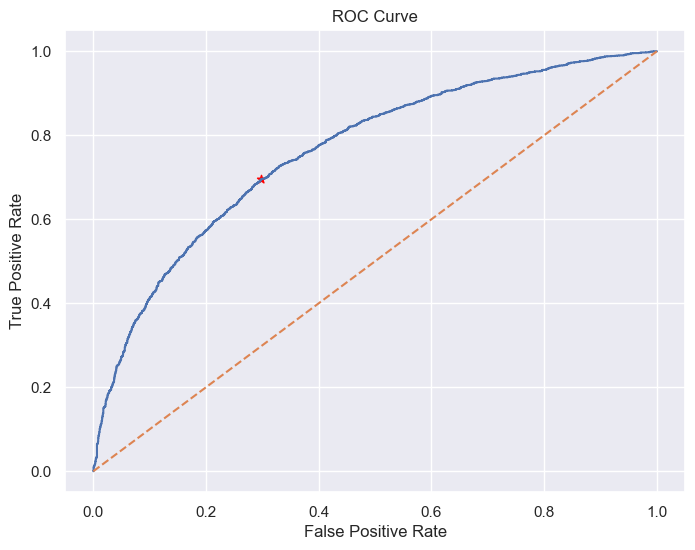

Traing Data Accuracy and Model Evaluation
Accuracy: 0.6987785203964048

Confusion Matrix:
[[1622  688]
 [ 619 1410]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71      2310
         1.0       0.67      0.69      0.68      2029

    accuracy                           0.70      4339
   macro avg       0.70      0.70      0.70      4339
weighted avg       0.70      0.70      0.70      4339



 ---------------------------------------- Test Data ---------------------------------------- 
 ROC Curve, Optimal Threshold, and Accuracy
Optimal Threshold: 0.47764580651002697
ROC Score with y_prob: 0.7519126501973171


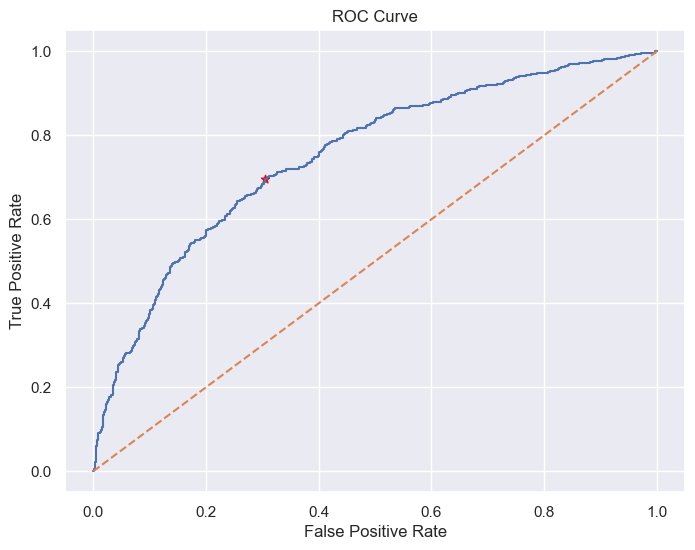

Test Data Accuracy and Model Evaluation
Accuracy: 0.6945404284727021

Confusion Matrix:
[[537 241]
 [201 468]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71       778
         1.0       0.66      0.70      0.68       669

    accuracy                           0.69      1447
   macro avg       0.69      0.69      0.69      1447
weighted avg       0.70      0.69      0.69      1447



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'sched_dep_time',
                                                   'carrier_flight_delay',
                                                   'origin_dest_delay',
                                                   'arr_delay', 'air_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dep_dayofweek', 'carrier',
                                                   'origin', 'arr_hour',
                                                   'day'])])),
                ('classifier',
                 LogisticRegression(C=10, l1_ratio=0.5, max_iter=1000,
                                    penalty='elasticnet', random_state=0,
                                    solver='saga'))])

In [60]:
print(f"{'--' * 20} Training Data {'--' * 20} \n ROC Curve, Optimal Threshold, and Accuracy ")
optimal_threshold_train = roc_plot_threshold(best_model_lg, X_train, y_train)
print("Traing Data Accuracy and Model Evaluation")
y_train_pred = evaluate_model(best_model_lg, X_train, y_train, threshold=optimal_threshold_train, detailed=True)

print(f"\n\n {'--' * 20} Test Data {'--' * 20} \n ROC Curve, Optimal Threshold, and Accuracy")
optimal_threshold_test = roc_plot_threshold(best_model_lg, X_test, y_test)
print("Test Data Accuracy and Model Evaluation")
y_test_pred = evaluate_model(best_model_lg, X_test, y_test, threshold=optimal_threshold_train, detailed=True)

model_path_lg = "../model/logistic_regression.pkl"
joblib.dump(best_model_lg, model_path_lg)
export_predictions_with_flags(y_test_pred, y_train_pred, "../data/flight_test_predictions_lg.csv")
best_model_lg

##### GradientBoostingClassifier

In [61]:
classifier = GradientBoostingClassifier(random_state=0)

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__loss": ["log_loss", "exponential"],
    "classifier__learning_rate": [0.01, 0.05],
    "classifier__max_depth": [1, 2],
    "classifier__min_samples_split": [10, 20],
    "classifier__min_samples_leaf": [4, 8],
}


# Best Parameters: {"classifier__learning_rate": 0.05, "classifier__loss": "exponential", "classifier__max_depth": 2, "classifier__min_samples_leaf": 8, "classifier__min_samples_split": 10, "classifier__n_estimators": 200}

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model_gb = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END classifier__learning_rate=0.01, classifier__loss=log_loss, classifier__max_depth=1, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__loss=log_loss, classifier__max_depth=1, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__loss=log_loss, classifier__max_depth=1, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__loss=log_loss, classifier__max_depth=1, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__loss=log_loss, classifier__max_depth=1, classifier__m

---------------------------------------- Training Data ---------------------------------------- 
 ROC Curve, Optimal Threshold, and Accuracy 
Optimal Threshold: 0.4575249932127642
ROC Score with y_prob: 0.7810102005764894


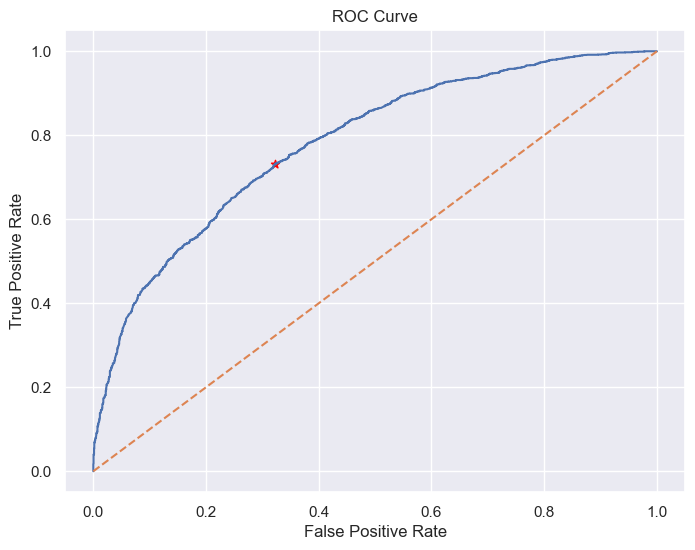

Traing Data Accuracy and Model Evaluation
Accuracy: 0.702926941691634

Confusion Matrix:
[[1565  745]
 [ 544 1485]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      2310
         1.0       0.67      0.73      0.70      2029

    accuracy                           0.70      4339
   macro avg       0.70      0.70      0.70      4339
weighted avg       0.71      0.70      0.70      4339



 ---------------------------------------- Test Data ---------------------------------------- 
 ROC Curve, Optimal Threshold, and Accuracy
Optimal Threshold: 0.5023412414863067
ROC Score with y_prob: 0.7528415968275559


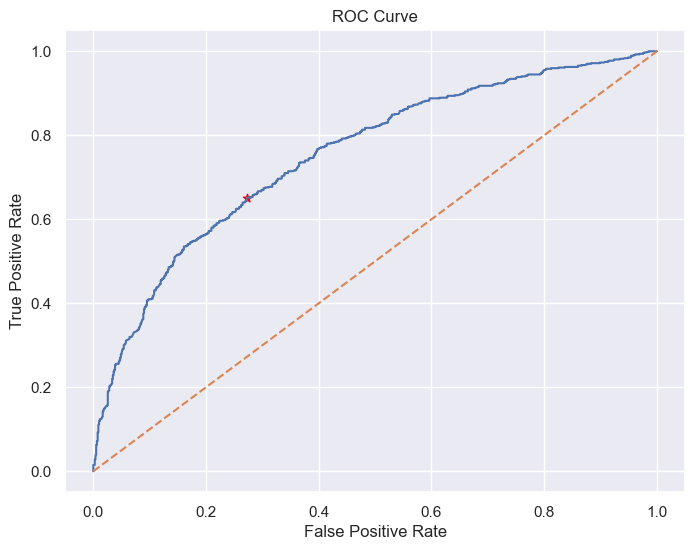

Test Data Accuracy and Model Evaluation
Accuracy: 0.6772633033863165

Confusion Matrix:
[[501 277]
 [190 479]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.64      0.68       778
         1.0       0.63      0.72      0.67       669

    accuracy                           0.68      1447
   macro avg       0.68      0.68      0.68      1447
weighted avg       0.68      0.68      0.68      1447



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'sched_dep_time',
                                                   'carrier_flight_delay',
                                                   'origin_dest_delay',
                                                   'arr_delay', 'air_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dep_dayofweek', 'carrier',
                                                   'origin', 'arr_hour',
                                                   'day'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            loss='exponential', max_depth=2,
                                            min_samples_leaf=8,
                                            min_samples_split=10,
                                            n_estimators=200,
                                            random_state=0))])

In [63]:
print(f"{'--' * 20} Training Data {'--' * 20} \n ROC Curve, Optimal Threshold, and Accuracy ")
optimal_threshold_train = roc_plot_threshold(best_model_gb, X_train, y_train)
print("Traing Data Accuracy and Model Evaluation")
y_train_pred = evaluate_model(best_model_gb, X_train, y_train, threshold=optimal_threshold_train, detailed=True)

print(f"\n\n {'--' * 20} Test Data {'--' * 20} \n ROC Curve, Optimal Threshold, and Accuracy")
optimal_threshold_test = roc_plot_threshold(best_model_gb, X_test, y_test)
print("Test Data Accuracy and Model Evaluation")
y_test_pred = evaluate_model(best_model_gb, X_test, y_test, threshold=optimal_threshold_train, detailed=True)


model_path_gb = "../model/gradient_boosting.pkl"
joblib.dump(best_model_gb, model_path_gb)
export_predictions_with_flags(y_test_pred, y_train_pred, "../data/flight_test_predictions_gb.csv")
best_model_gb

### Select Model and Backtest on filtered flight history dataset

In [65]:
# latest_model = joblib.load(model_path_lg)
latest_model = joblib.load(model_path_gb)

filtered_history_2_df = (
    filtered_history_df.merge(origin_dest_delay_df, on=["origin", "dest"], how="left")
    .merge(carrier_flight_delay_df, on=["carrier", "flight"], how="left")
    .merge(day_delay_df, on=["day"], how="left")
)
filtered_history_2_df.dropna(subset=["lateflight"], inplace=True)

print(f"Training Accuracy {latest_model.score(X_train, y_train)}")
print(f"Test Accuracy {latest_model.score(X_test, y_test)}")
cv_scores = cross_val_score(latest_model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Mean CV Accuracy: {np.mean(cv_scores)} <-- {cv_scores}")
print(f"Backtest Accuracy {latest_model.score(filtered_history_2_df.drop(columns=['lateflight']), filtered_history_2_df['lateflight'])}")

Training Accuracy 0.7052316201889837
Test Accuracy 0.6890117484450587
Mean CV Accuracy: 0.679647494671493 <-- [0.69470046 0.65898618 0.70506912 0.66935484 0.67012687]
Backtest Accuracy 0.6332487940723059


### Explore the misclassifications

In [66]:
data_pred_df = pd.read_csv("../data/flight_test_predictions_gb.csv")
data_pred_df.describe(include="all")

,uniqueid,dep_dayofweek,carrier,origin,arr_hour,day,distance,sched_dep_time,carrier_flight_delay,origin_dest_delay,arr_delay,air_time,lateflight,predicted,carrier_delay,day_delay,dayofweek_delay,dep_delay,dest,dest_delay,flight,hour,minute,month,origin_delay,sched_arr_time,speed,tailnum,tailnum_delay,time_hour,year,split
count,5786.000000,5786.000000,5786,5786,5786.000000,5786.000000,5762.000000,5786.000000,5523.000000,5762.000000,5523.000000,5054.000000,5786.000000,5786.000000,5786.000000,5786.000000,5786.000000,5524.000000,5786,5784.000000,5786.000000,5786.000000,5786.000000,5786.0,5786.000000,5786.000000,5523.000000,5786,5682.000000,5786,5786.0,5786
unique,NaN,NaN,15,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2210,NaN,557,NaN,2
top,NaN,NaN,UA,EWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N722MQ,NaN,2013-07-01 06:00:00,NaN,train
freq,NaN,NaN,1032,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,26,NaN,4339
mean,2996.742309,2.689768,NaN,NaN,14.692534,16.206533,1079.420687,1329.121846,0.448576,0.427565,1.344469,153.425505,0.466298,0.516073,0.434046,0.409724,0.408695,4.179852,NaN,0.422162,1915.626339,13.021258,26.996025,7.0,0.411154,1498.356377,399.716388,NaN,0.431816,NaN,2013.0,NaN
std,1734.737871,1.981162,NaN,NaN,5.155793,8.944023,750.466055,475.023748,0.189505,0.100037,18.918842,93.628615,0.498906,0.499785,0.079902,0.064487,0.043988,14.800056,NaN,0.080964,1595.863880,4.733492,19.398879,0.0,0.037047,517.208580,52.175886,NaN,0.161691,NaN,0.0,NaN
min,1.000000,0.000000,NaN,NaN,0.000000,1.000000,94.000000,500.000000,0.000000,0.000000,-47.000000,30.500000,0.000000,0.000000,0.220994,0.319744,0.306507,-8.000000,NaN,0.000000,1.000000,5.000000,0.000000,7.0,0.380494,1.000000,151.578947,NaN,0.000000,NaN,2013.0,NaN
25%,1493.250000,1.000000,NaN,NaN,10.000000,9.000000,529.000000,900.000000,0.302309,0.354227,-9.500000,84.000000,0.000000,0.000000,0.354194,0.357576,0.405538,-3.000000,NaN,0.360539,573.000000,9.000000,9.000000,7.0,0.380494,1058.000000,375.384615,NaN,0.328125,NaN,2013.0,NaN
50%,2997.500000,2.000000,NaN,NaN,15.000000,16.000000,937.000000,1340.000000,0.438356,0.412331,-3.000000,134.250000,0.000000,1.000000,0.384568,0.398812,0.418541,-0.500000,NaN,0.428102,1464.000000,13.000000,29.000000,7.0,0.388297,1520.000000,410.952381,NaN,0.428571,NaN,2013.0,NaN
75%,4505.750000,4.000000,NaN,NaN,19.000000,24.000000,1416.000000,1720.000000,0.565217,0.471591,5.000000,196.000000,1.000000,1.000000,0.512915,0.459893,0.451524,4.000000,NaN,0.471831,3351.000000,17.000000,45.000000,7.0,0.461667,1927.000000,436.571429,NaN,0.520000,NaN,2013.0,NaN


In [67]:
def barchart_hue_1x2(df, y_column, x_columns_list, hue_column, title_str):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for i, column in enumerate(x_columns_list):
        sns.barplot(x=column, y=y_column, hue=hue_column, data=df, ax=axes[i])
        axes[i].set_title(f"{title_str} distribution for {column}")
    plt.show()

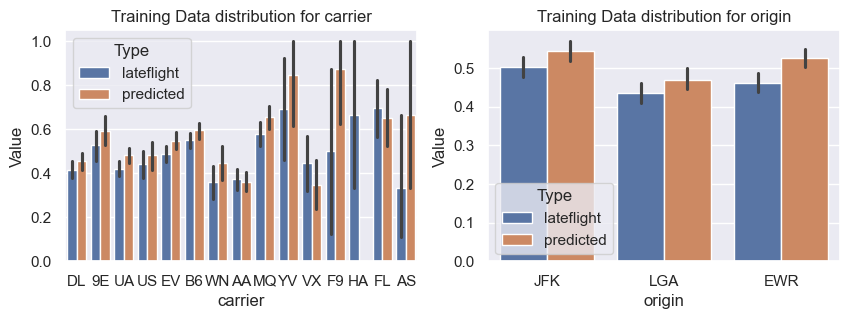

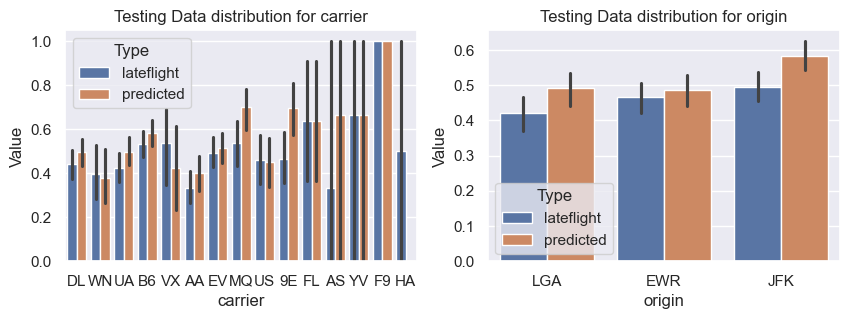

In [68]:
df_train = pd.melt(
    data_pred_df[data_pred_df["split"] == "train"],
    id_vars=list(data_pred_df.drop(columns=["lateflight", "predicted"]).columns),
    value_vars=["lateflight", "predicted"],
    var_name="Type",
    value_name="Value",
)
df_test = pd.melt(
    data_pred_df[data_pred_df["split"] == "test"],
    id_vars=list(data_pred_df.drop(columns=["lateflight", "predicted"]).columns),
    value_vars=["lateflight", "predicted"],
    var_name="Type",
    value_name="Value",
)

barchart_hue_1x2(df_train, "Value", ["carrier", "origin"], "Type", "Training Data")
barchart_hue_1x2(df_test, "Value", ["carrier", "origin"], "Type", "Testing Data")